## [1] Setup e Import

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import asyncio
import json

# path del server MCP
sys.path.insert(0, str(Path.cwd().parent / 'mcp_server'))

## [2] Caricamento Dati

Il dataset contiene:
- **Users**: 20 utenti
- **Items**: 30 items (ID: 101-203)
- **Ratings**: ~500 ratings (scala 1-5)

In [2]:
# Carica il dataset
data_path = Path.cwd().parent / 'data' / 'ratings.csv'
df = pd.read_csv(data_path)

print(f" Dataset caricato: {len(df)} ratings")
print(f" Utenti unici: {df['user_id'].nunique()}")
print(f" Items unici: {df['item_id'].nunique()}")
print(f" Rating medio: {df['rating'].mean():.2f}")
print("\n Prime 10 righe:")
df.head(10)

 Dataset caricato: 321 ratings
 Utenti unici: 20
 Items unici: 84
 Rating medio: 4.03

 Prime 10 righe:


,user_id,item_id,rating
0,2,120,4.0
1,7,116,4.0
2,10,148,5.0
3,12,142,3.0
4,18,184,4.0
5,12,131,5.0
6,12,152,3.0
7,17,179,5.0
8,16,141,5.0
9,7,127,4.0


## [3] Analisi Esplorativa dei Dati

In [3]:
# Statistiche per utente
user_stats = df.groupby('user_id').agg({
    'item_id': 'count',
    'rating': ['mean', 'std']
}).round(2)

user_stats.columns = ['num_ratings', 'avg_rating', 'std_rating']
user_stats = user_stats.sort_values('num_ratings', ascending=False)

print("Top 10 utenti più attivi:")
user_stats.head(10)

Top 10 utenti più attivi:


,num_ratings,avg_rating,std_rating
user_id,,,
15,23,4.00,1.04
8,20,3.55,1.00
2,20,4.10,0.85
14,19,4.05,0.52
17,17,4.24,0.83
5,17,3.94,0.97
9,17,4.29,0.69
16,16,4.19,1.11
10,16,4.19,0.66


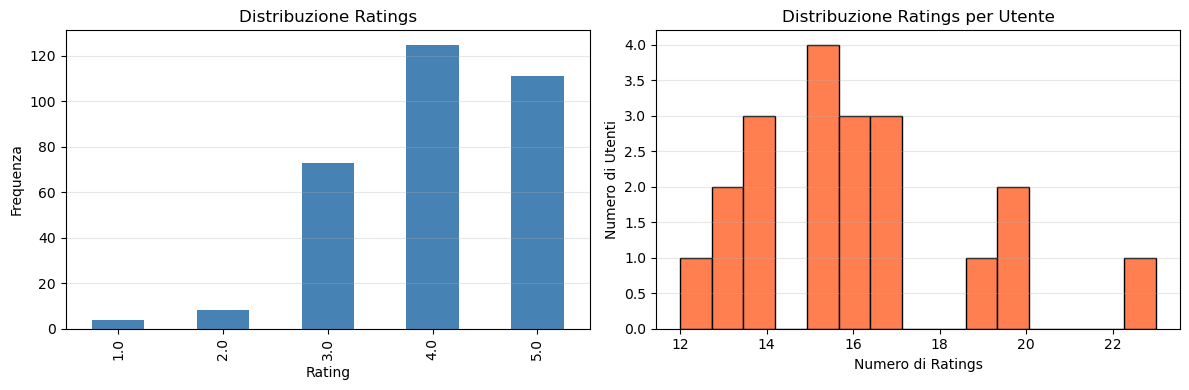

Sparsity: 80.9%


In [4]:
# Distribuzione dei ratings
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribuzione ratings
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribuzione Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequenza')
axes[0].grid(axis='y', alpha=0.3)

# Ratings per utente
ratings_per_user = df.groupby('user_id').size()
axes[1].hist(ratings_per_user, bins=15, color='coral', edgecolor='black')
axes[1].set_title('Distribuzione Ratings per Utente')
axes[1].set_xlabel('Numero di Ratings')
axes[1].set_ylabel('Numero di Utenti')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sparsity: {(1 - len(df) / (df['user_id'].nunique() * df['item_id'].nunique())) * 100:.1f}%")

## [4] Test delle Funzioni MCP Server

Importiamo e testiamo le funzioni del server MCP direttamente.

In [5]:
# Import delle funzioni dal server MCP
from recommender_server import (
    load_or_initialize_data,
    get_recommendations,
    add_rating,
    get_similar_users,
    get_user_stats
)

# Inizializza i dati
load_or_initialize_data()

Loaded 321 ratings from c:\Users\Patrick\Desktop\Progetto Recommender Systems\data\ratings.csv
Loaded 103 movies from c:\Users\Patrick\Desktop\Progetto Recommender Systems\data\movies.csv


### 4.1 - Statistiche Utente

In [7]:
# Test: Ottieni statistiche per un utente
user_id = 17

result = await get_user_stats(user_id=user_id)
stats = eval(result)  # Converti stringa a dict

print(f"Statistiche Utente {user_id}:")
print(f"Total ratings: {stats['total_ratings']}")
print(f"Average rating: {stats['average_rating']:.2f}")
print(f"Min rating: {stats['min_rating']}")
print(f"Max rating: {stats['max_rating']}")
print(f"Rated items: {stats['rated_items']}")

Statistiche Utente 17:
Total ratings: 17
Average rating: 4.24
Min rating: 3.0
Max rating: 5.0
Rated items: [179, 158, 161, 154, 180, 192, 172, 181, 184, 186, 163, 149, 173, 190, 147, 152, 18]


### 4.2 - Utenti Simili

In [8]:
user=17
# Test: Trova utenti simili
result = await get_similar_users(user_id=user, top_n=5)
similar = eval(result)

print(f" Utenti simili a User {similar['user_id']}:\n")
for sim_user in similar['similar_users']:
    print(f"   User {sim_user['user_id']}: similarity = {sim_user['similarity_score']:.4f}")

 Utenti simili a User 17:

   User 8: similarity = 0.7887
   User 18: similarity = 0.6768
   User 19: similarity = 0.5456
   User 20: similarity = 0.5000
   User 15: similarity = 0.4653


### 4.3 - Raccomandazioni (Collaborative Filtering)

In [ ]:
user=1
# Test: Ottieni raccomandazioni
result = await get_recommendations(user_id=user, top_n=5)
recommendations = eval(result)

print(f"Raccomandazioni per User {recommendations['user_id']}:\n")
for rec in recommendations['recommendations']:
    print(f" Item {rec['title']}: predicted rating = {rec['predicted_rating']:.2f}")

Raccomandazioni per User 1:

 Item Salvate il Soldato Ryan: predicted rating = 5.00
 Item The Prestige: predicted rating = 5.00
 Item The Revenant: predicted rating = 5.00
 Item Shawshank Redemption: predicted rating = 5.00
 Item Dunkirk: predicted rating = 4.89


### 4.4 - Aggiungi Nuovo Rating

In [10]:
user=3
item_id=105
rating=2

# Test: Aggiungi un nuovo rating
result = await add_rating(user_id=user, item_id=item_id, rating=rating)
print(result)

# Verifica le nuove raccomandazioni
result = await get_recommendations(user_id=2, top_n=3)
new_recommendations = eval(result)

print(f"\n Nuove raccomandazioni dopo il rating:")
for rec in new_recommendations['recommendations']:
    print(f" Item {rec['title']}: predicted rating = {rec['predicted_rating']:.2f}")

Updated rating: User 3 rated Item 105 as 2


Updated rating: User 3 rated Item 105 as 2

 Nuove raccomandazioni dopo il rating:
 Item The Social Network: predicted rating = 5.00
 Item Salvate il Soldato Ryan: predicted rating = 5.00
 Item The Prestige: predicted rating = 5.00


## [5] Analisi Algoritmo Collaborative Filtering

### Come Funziona:

L'algoritmo di **User-Based Collaborative Filtering** predice i rating mancanti in tre passi:

#### 1. **Mean Centering** - Normalizzazione dei Rating

Per ogni utente $u$, si centra il rating rispetto alla sua media personale:

$$s_{uj} = r_{uj} - \mu_u, \quad \forall u \in \{1, \ldots, m\}$$

Dove:
- $r_{uj}$ = rating originale dell'utente $u$ per l'item $j$
- $\mu_u$ = media dei rating dell'utente $u$
- $s_{uj}$ = rating centrato (mean-centered)

**Motivazione**: Elimina bias individuali (alcuni utenti danno sempre voti alti, altri sempre bassi)

#### 2. **Predizione Rating** - Weighted Average + Denormalizzazione

Sia $P_u(j)$ l'insieme dei $k$ utenti più simili a $u$ che hanno valutato l'item $j$.

La predizione finale è:

$$\hat{r}_{uj} = \mu_u + \frac{\sum_{v \in P_u(j)} \text{Pearson}(u,v) \cdot s_{vj}}{\sum_{v \in P_u(j)} |\text{Pearson}(u,v)|}$$

**Componenti**:
- $\mu_u$ = **baseline dell'utente** (riporta alla sua scala personale)
- Numeratore = **somma pesata** dei rating centrati degli utenti simili
- Denominatore = **normalizzazione** (somma dei valori assoluti delle similarità)


In [14]:
### 5.1 Visualizzazione Matrice User-Item Originale
# Ricarica il dataset aggiornato dopo add_rating
df = pd.read_csv(data_path)

# Visualizziamo la matrice user-item
user_item_matrix = df.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating'
)

# Mostra porzione della matrice per i primi 5 utenti e 10 item
print("User-Item Matrix ORIGINALE (parziale - primi 5 utenti, 10 item):")
print(user_item_matrix.iloc[:5, :10].fillna('-'))

# Calcola sparsity
total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
filled_cells = user_item_matrix.notna().sum().sum()
sparsity = (1 - filled_cells / total_cells) * 100

print(f"Sparsity della matrice: {sparsity:.1f}%")
print(f"Celle totali: {total_cells}")
print(f"Celle con rating: {filled_cells}")
print(f"Celle vuote (da predire): {total_cells - filled_cells}")

User-Item Matrix ORIGINALE (parziale - primi 5 utenti, 10 item):
item_id 18   101  102  103  104  105  106  107  108  109
user_id                                                 
1         -    -  3.0    -    -  4.0  5.0    -  4.0  3.0
2         -  5.0  5.0  5.0  3.0    -  5.0    -  5.0  4.0
3         -  4.0  4.0  3.0    -  2.0    -  4.0  5.0    -
4         -    -    -    -  4.0  4.0    -    -    -    -
5         -  4.0  5.0    -    -  2.0    -    -  4.0  4.0
Sparsity della matrice: 80.9%
Celle totali: 1680
Celle con rating: 321
Celle vuote (da predire): 1359


In [16]:
### 5.2 Step 1: Calcolo Medie Utenti (μ_u)

# Calcola la media di ogni utente
user_means = user_item_matrix.mean(axis=1, skipna=True)

print("Media rating per utente (μ_u):")
print(user_means.head(10).round(2))


Media rating per utente (μ_u):
user_id
1     4.13
2     4.10
3     4.07
4     4.00
5     3.94
6     4.33
7     4.20
8     3.55
9     4.29
10    4.19
dtype: float64


In [17]:
### 5.3 Step 2: Mean Centering (s_uj = r_uj - μ_u)
centered_matrix = user_item_matrix.sub(user_means, axis=0)

print("Matrice CENTRATA (parziale - primi 5 utenti, 10 item):")
print(centered_matrix.iloc[:5, :10].round(2).fillna('-'))

Matrice CENTRATA (parziale - primi 5 utenti, 10 item):
item_id 18    101   102   103  104   105   106   107   108   109
user_id                                                         
1         -     - -1.13     -    - -0.13  0.87     - -0.13 -1.13
2         -   0.9   0.9   0.9 -1.1     -   0.9     -   0.9  -0.1
3         - -0.07 -0.07 -1.07    - -2.07     - -0.07  0.93     -
4         -     -     -     -  0.0   0.0     -     -     -     -
5         -  0.06  1.06     -    - -1.94     -     -  0.06  0.06


In [19]:
### 5.4 Step 3: Calcolo Similarità Pearson

from recommender_server import calculate_user_similarity

# Calcola matrice di similarità tra TUTTI gli utenti
n_users = len(user_item_matrix)
similarity_matrix = pd.DataFrame(
    index=user_item_matrix.index,
    columns=user_item_matrix.index,
    dtype=float
)

for user_i in user_item_matrix.index:
    for user_j in user_item_matrix.index:
        if user_i == user_j:
            similarity_matrix.loc[user_i, user_j] = 1.0  # Similarità con se stesso
        else:
            sim = calculate_user_similarity(
                user_item_matrix.loc[user_i],
                user_item_matrix.loc[user_j]
            )
            # La funzione restituisce [0,1], convertiamo in [-1,1] per Pearson
            similarity_matrix.loc[user_i, user_j] = (sim * 2) - 1

print("Matrice Similarità (Pearson) - parziale (primi 8x8 utenti):")
print(similarity_matrix.iloc[:8, :8].round(3))


Matrice Similarità (Pearson) - parziale (primi 8x8 utenti):
user_id      1      2      3      4      5      6      7    8
user_id                                                      
1        1.000  0.231  0.000  0.894 -0.524 -0.482  0.585 -0.5
2        0.231  1.000 -0.165 -0.296  0.214 -0.122  0.000 -1.0
3        0.000 -0.165  1.000 -0.354  0.780 -0.645  0.182 -1.0
4        0.894 -0.296 -0.354  1.000 -0.493 -1.000  0.906 -1.0
5       -0.524  0.214  0.780 -0.493  1.000  0.658 -0.173 -1.0
6       -0.482 -0.122 -0.645 -1.000  0.658  1.000 -0.246 -1.0
7        0.585  0.000  0.182  0.906 -0.173 -0.246  1.000 -0.5
8       -0.500 -1.000 -1.000 -1.000 -1.000 -1.000 -0.500  1.0


In [22]:
### 5.5 Step 4: Predizione r̂_uj con Formula Completa

# Creiamo una matrice per contenere le predizioni
predicted_matrix = user_item_matrix.copy()

k_neighbors = 5  # Numero di vicini da considerare

# Per ogni utente
for user_id in user_item_matrix.index:
    user_mean = user_means[user_id]
    user_ratings = user_item_matrix.loc[user_id]
    
    # Trova i k utenti più simili (escluso se stesso)
    similarities = similarity_matrix.loc[user_id].drop(user_id).astype(float)
    similarities = similarities[similarities > 0].sort_values(ascending=False)
    top_k_similar = similarities.head(k_neighbors)
    
    # Per ogni item NON ancora valutato dall'utente
    for item_id in user_item_matrix.columns:
        if pd.isna(user_ratings[item_id]):  # Se manca il rating
            
            # Trova utenti simili che hanno valutato questo item
            numerator = 0.0
            denominator = 0.0
            
            for similar_user, pearson_sim in top_k_similar.items():
                similar_rating = user_item_matrix.loc[similar_user, item_id]
                
                if pd.notna(similar_rating):  # Se l'utente simile ha valutato
                    # s_vj = r_vj - μ_v (rating centrato dell'utente simile)
                    centered_rating = similar_rating - user_means[similar_user]
                    
                    # Formula completa
                    numerator += pearson_sim * centered_rating
                    denominator += abs(pearson_sim)
            
            # Calcola predizione: r̂_uj = μ_u + weighted_avg
            if denominator > 0:
                prediction = user_mean + (numerator / denominator)
                
                # Clamp tra 1 e 5
                prediction = max(1.0, min(5.0, prediction))
                
                predicted_matrix.loc[user_id, item_id] = prediction

print("User-Item Matrix con PREDIZIONI (r̂_uj) - parziale:")
print(predicted_matrix.iloc[:5, :10].round(2))




User-Item Matrix con PREDIZIONI (r̂_uj) - parziale:
item_id  18    101   102   103   104  105   106   107   108   109
user_id                                                          
1        NaN  3.53  3.00  5.00  3.91  4.0  5.00   NaN  4.00  3.00
2        NaN  5.00  5.00  5.00  3.00  3.1  5.00   NaN  5.00  4.00
3        NaN  4.00  4.00  3.00   NaN  2.0  4.87  4.00  5.00  4.13
4        NaN  2.80  3.34   NaN  4.00  4.0  4.83   NaN  3.87  2.87
5        NaN  4.00  5.00  3.67   NaN  2.0  3.61  3.75  4.00  4.00
